In [1]:
# pip install transformers
# pip install seqeval
# pip install pandas
# pip install numpy
# pip install matplotlib
# pip install seaborn
# !pip install scikit-learn
# !pip install torch torchvision
# !pip install nltk
# !pip install  spacy
# !pip install scipy
# !pip install yellowbrick
# !pip install tqdm
# !pip install openpyxl
# !pip install nlpaug

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import transformers
import torch
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, random_split, Dataset
from transformers import BertTokenizer, BertModel, BertConfig
import numpy as np
import torch.nn as nn

C:\Users\z004z4ut\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path="final data.xlsx"
data=pd.read_excel(path)
data.sample(10)

,sentence,intent
231,How can I add a 'KNOWS' relationship between n...,add relationship
172,"Seriously, how hard is it to add a few propert...",add property
44,I need a new node with the label 'Strait'.,add node
271,I want to create a 'MEMBER_OF' relationship be...,add relationship
102,Please erase the node connected to the concept...,delete node
52,I need a new node with the label 'City'.,add node
47,Please add a 'Planet' node.,add node
115,I want to remove the node related to the time ...,delete node
39,I need a new node with the label 'Island'.,add node
195,Link node ID 345 to node ID 987 with the relat...,add property


In [4]:
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

### DATA EXPLORATION

In [5]:
print("Total number of instances:")
print(len(data))

Total number of instances:
314


Text(0.5, 1.0, 'Distribution of data among classes in dataset.')

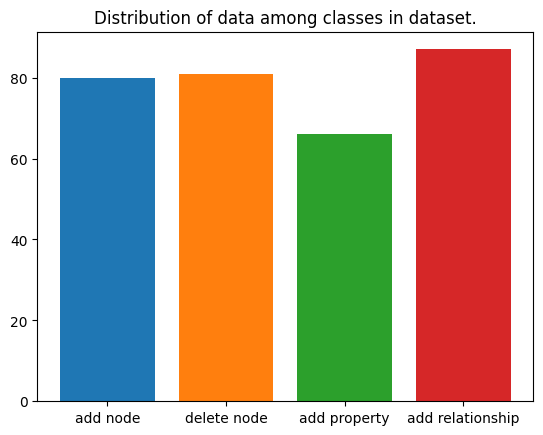

In [6]:
classes=data['intent'].unique()
countDict={}
for Class in classes:
    countDict[Class]=data['intent'].value_counts().get(Class,0)
for Class,count in countDict.items():
    plt.bar(Class,count)
plt.title('Distribution of data among classes in dataset.')

Since the distribution of data among the classes is not too imbalanced, we do not need to perform normalization. 

### DATA PRE-PROCESSING

As BERT is trained on a corpus of full sentences of natural language and the embedding process involves contextual embedding, performing stop-word removal might interfere with the accurate functioning of BERT. So we do not remove stop words from our input. This is also why we will not be performing stemming or lemmatization.

removing all punctuation marks except '' and "" as the specifics of graph manipulation are expected to be input in quotes.

In [7]:
import string
def removePunctuation(sentence):
    cleaned="".join([char for char in sentence if char not in string.punctuation or char=="'" or char=='"'])    
    return cleaned

In [8]:
data['sentence'] =data['sentence'].apply(removePunctuation) #remove punctuation from data

convert all classes to numerical classes <br>

In [9]:
ClassNumber=0
for Class in data['intent'].unique():
    print(f'Class name:{Class}-->number: {ClassNumber}')
    data['intent']=data['intent'].replace(Class,ClassNumber)
    ClassNumber+=1

Class name:add node-->number: 0
Class name:delete node-->number: 1
Class name:add property-->number: 2
Class name:add relationship-->number: 3


C:\Users\z004z4ut\AppData\Local\Temp\ipykernel_7920\41222258.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['intent']=data['intent'].replace(Class,ClassNumber)


In [10]:
data.sample(10)

,sentence,intent
15,Please add a 'Historical Figure' node,0
192,Set the property 'status 'completed' 'successf...,2
194,Create a relationship 'colleague' between node...,2
259,I need to establish a 'LOCATEDIN' relationship...,3
198,Link node ID 123 to node ID 456 with the relat...,2
21,Make a new node with the label 'Politician',0
189,Create a node with the property 'name Bob' 'ag...,2
282,Could you create a 'PARTOF' relationship betwe...,3
62,make a node,0
123,Can you erase the node associated with the ass...,1


**PRE-PROCESSING FOR BERT** <br>
1. [CLS] and [SEP] are special tokens that BERT requires. this is because BERT was orginally trained for Q-A tasks. For classfn tasks, BERT requires another special token. All of these tokens are in-built in the hugging face tokenizer. 
2. All sequences must be of the same length, so we need to do padding. We do the padding on the right side which is preferred for BERT.
3. Finally we pass in attention mask to assign importance to each token. So all non-padding tokens are assigned an attention of 1 and padding tokens 0.
<br><br>
<i>Since BERT takes the input ids, attention mask and target classes as 3 separate outputs, we can create a dataset where each of them are a separate column to make our program more readable.<i>

Hugging face's BERT tokenizer uses pre trained BERT base, a small version of BERT. we use cased BERT because we want our model to be case sensitive, which will be important for paramter extraction in the named entity recognition layer.

In [11]:
def preProcess(data):
    tokenizer=BertTokenizer.from_pretrained('bert-base-cased')
    input_ids_list=[]
    attention_masks_list=[]
    intents_list=[]
    for sentence,label in zip(data['sentence'],data['intent']):
        encoding=tokenizer.encode_plus(
            sentence,
            add_special_tokens= True,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt' #pt signifies pyTorch, use tf for tensorFlow & keras
        )
        input_ids_list.append(encoding['input_ids'])
        attention_masks_list.append(encoding['attention_mask'])
        intents_list.append(torch.tensor(label).long()) #most transformer models and BERT expect input data to be of the type LongTensor
    #to ensure that all of our tensors have the same shape we use cat()
    input_ids_list = torch.cat(input_ids_list)
    attention_masks_list = torch.cat(attention_masks_list)
    intents_list = torch.stack(intents_list)
    dataset=TensorDataset(input_ids_list,attention_masks_list,intents_list)
    return dataset

In [12]:
dataset=preProcess(data)

In [25]:
# for i in range(1):
#     input_ids, attention_mask, intent = dataset[i]
#     print(f"Input IDs: {input_ids}")
#     print(f"Attention Mask: {attention_mask}")
#     print(f"Intent: {intent}")
#     print()

### TRAINING AND MODEL ARCHITECTURE

Creating train and test sets with dataloader

In [14]:
train_percent=0.8
test_percent=0.2
train_data,test_data=random_split(dataset,[train_percent,test_percent])

In [15]:
#we do not have to define custom dataset with Dataset class as we've used TensorDataset() on our data.
bSize=4
trainingData=DataLoader(train_data,batch_size=bSize,shuffle=True)
testingData=DataLoader(test_data,batch_size=bSize,shuffle=True)

In [24]:
print("Training data format:")
for batch in enumerate(trainingData):
    _,tensor=batch
    print(tensor)
    # for i in range(bSize):    
    #     input_ids = tensor[0][i]
    #     attention_mask = tensor[1][i]
    #     labels = tensor[2][i]
    #     print(f'BATCH ELEMENT {i}---------------------')
    #     print("Input IDs:", input_ids)
    #     print("Attention Mask:", attention_mask)
    #     print("Labels:", labels)
    break

Training data format:
[tensor([[  101,   146,   112,  ...,     0,     0,     0],
        [  101,  2825,  1128,  ...,     0,     0,     0],
        [  101, 24930,  1181,  ...,     0,     0,     0],
        [  101,   146,  1328,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([1, 0, 2, 1])]


Define model architecture

1. BERT with default configuration followed by a dropout layer and a classfication layer (dense layer)

In [17]:
class BERTmodel(nn.Module):
    def __init__(self):
        super(BERTmodel, self).__init__()
        self.configuration=BertConfig()
        self.bert=transformers.BertModel(self.configuration)
        self.dropout=nn.Dropout(0.3)
        self.linear=nn.Linear(768,4) #768 is the output size of BERT and 4 is the number of output classes we have
    
    def forward(self,ip_ids,attention_masks):
        _, op= self.bert(ip_ids, attention_mask = attention_masks,return_dict=False) #op is the embedding of all input tokens and also special tokens. placeholder is only for input tokens.
        op=self.dropout(op)
        op=self.linear(op)
        return op    

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
model = BERTmodel().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 50

TRAINING LOOP

In [ ]:
lossList=[]
for epoch in range(epochs):
    model.train()
    for _,data in enumerate(trainingData):
        ip_ids=data[0].to(device)
        mask=data[1].to(device)
        target=data[2].to(device)
        optimizer.zero_grad()
        predictions=model(ip_ids,mask)
        loss=loss_fn(predictions,target)
        loss.backward()
        optimizer.step()
    if epoch%10==0:
        print(f"{epoch} epoch: loss ={loss}")
        lossList.append(loss.item())

In [ ]:
plt.plot(lossList)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs Vs Loss")